In [1]:
from credit_helper import *
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
mydir = os.getcwd()

---
---

### HW1Q1 - Explore symbology for US treasuries and corporate bonds
1. Load the `govt_symbology` Excel file into a dataframe. For each government bond issue, calculate its initial term/time-to-maturity in years (based on issue date and maturity date), as well as the current time-to-maturity. Assume a year has 365.25 days, or use QuantLib yearFraction() function.
2. Plot the time series of coupons for for US treasury notes/bonds issued in the last 10 years (indexed by issue date). What can you say about the overall level of the coupons in the last 2 years?
3. Load the `govt_on_the_run` Excel file into a dataframe. Select the current on-the-run 2Y, 3Y, 5Y, 7Y, 10Y, 20Y and 30Y issues (off-the-run issues have the B & C suffix). Create a separate symbology dataframe for on-the-run treasuries only, to be used later on for the on-the-run government yield curve bootstrapping.
4. Load the `corp_symbology` Excel file into a dataframe. 
5. Create a new (filtered) dataframe for 
   * bullet/non-callable (mty_typ="AT MATURITY"), 
   * senior unsecured (rank = "Sr Unsecured"),
   * fixed coupon (cpn_type="FIXED") <br>
 
where, 
   * `term` refers to the initial term/time-to-maturity in years
   * `TTM` refers to the current time-to-maturity in years
>


In [3]:
govt_symbology = pd.read_excel(os.path.join(mydir , 'data' , 'govt_symbology.xlsx'))
govt_symbology = govt_symbology[govt_symbology['cpn_type'] == 'FIXED']
govt_symbology = govt_symbology.reset_index(drop=True)
govt_symbology = get_symbology(govt_symbology)

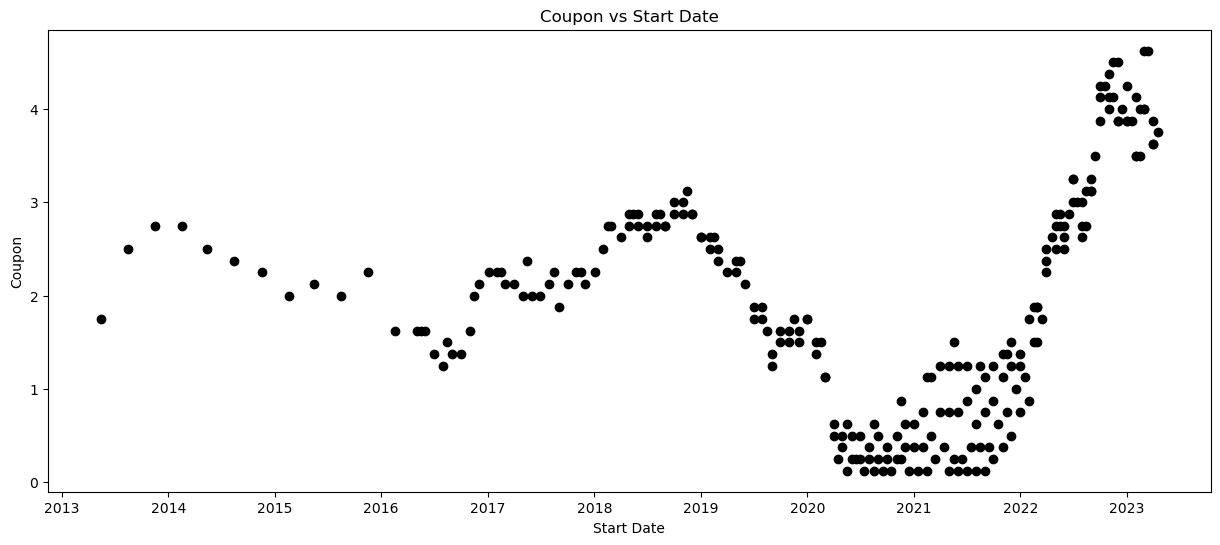

In [4]:
#filter out the start dates older than 10 years from 04/14/2023
govt_symbology_plot = govt_symbology[govt_symbology['term'] <= 10]
#remove all the zero coupon bonds
govt_symbology_plot = govt_symbology_plot[govt_symbology_plot['coupon'] != 0]
#create scatter plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(govt_symbology_plot['start_date'], govt_symbology_plot['coupon'], color='black')
ax.set_xlabel('Start Date')
ax.set_ylabel('Coupon')
ax.set_title('Coupon vs Start Date')
plt.show()

In [5]:
gov_otr = pd.read_excel(os.path.join(mydir , 'data' , 'govt_on_the_run.xlsx'))
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('B')]
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('C')]
gov_otr.reset_index(drop=True, inplace=True)
gov_otr_symbology = govt_symbology[govt_symbology['isin'].isin(gov_otr['isin'])]
gov_otr_symbology.sort_values(by=['TTM'], inplace=True)
gov_otr_symbology = get_symbology(gov_otr_symbology)

### HW1Q2 - Explore EOD market prices and yields
1. Load the `market_prices_eod` Excel file into a dataframe. It provides market data for US treasuries and corporate bonds of 2023-04-14. Join the treasuries symbology dataframe with the market data
2. Plot a graph/scatter plot of treasury mid yields by TTM.
3. Create a separate joint dataframe for on-the-run treasuries only.
4. Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.
5. Join the filtered corporate bonds symbology dataframe with the market data.
6. Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).
7. Add a separate line for on-the-run US treasury yield curve (risk free curve). What can you say about the credit issuer yields, compared to US treasury yields?

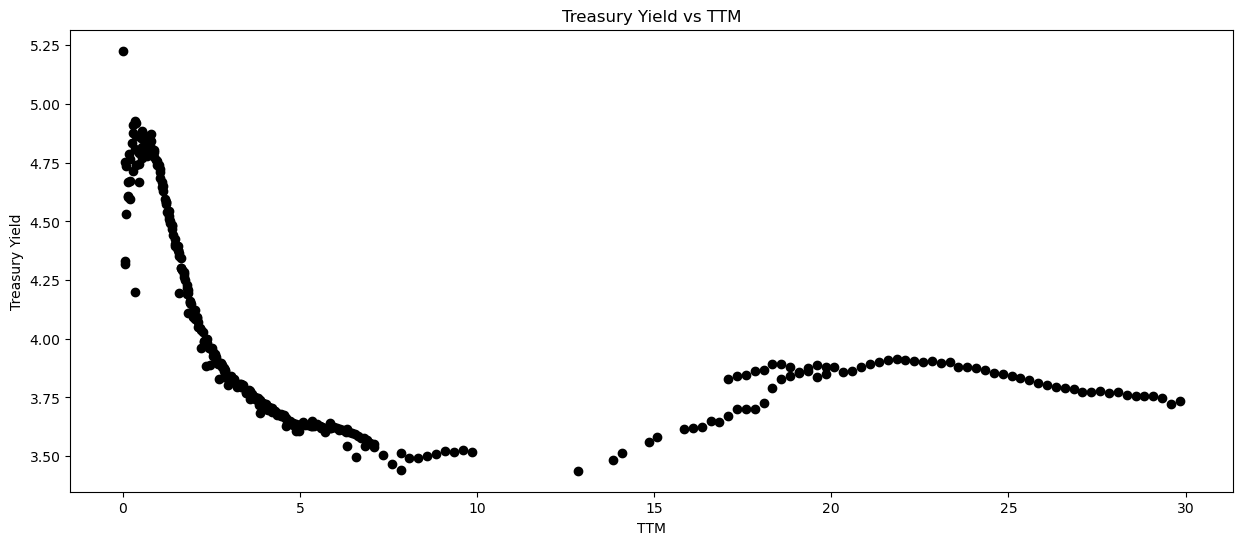

In [6]:
md = pd.read_excel(os.path.join(mydir , 'data' , 'market_prices_eod.xlsx'))
govt_symbology_md = pd.merge(govt_symbology, md, on='figi', how='inner', suffixes=('', '_y'))
govt_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
govt_symbology_md['mid_yield'] = (govt_symbology_md['ask_yield'] + govt_symbology_md['bid_yield'])/2
govt_symbology_md.sort_values(by=['mid_yield'], inplace=True)
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(govt_symbology_md['TTM'], govt_symbology_md['mid_yield'], color='black')
ax.set_xlabel('TTM')
ax.set_ylabel('Treasury Yield')
ax.set_title('Treasury Yield vs TTM')
plt.show()

In [7]:
corp_symbology = pd.read_excel(os.path.join(mydir , 'data' , 'corp_symbology.xlsx'))
corp_symbology = corp_symbology[(corp_symbology['mty_typ'] == 'AT MATURITY') & (corp_symbology['rank'] == 'Sr Unsecured') & (corp_symbology['cpn_type'] == 'FIXED')]
corp_symbology = get_symbology(corp_symbology, underlying=True)

corp_symbology_md = pd.merge(corp_symbology, md, on='figi', how='inner', suffixes=('', '_y'))
corp_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
corp_symbology_md.drop(columns=['ticker_y'], inplace=True)

corp_symbology_md['mid_yield'] = (corp_symbology_md['ask_yield'] + corp_symbology_md['bid_yield'])/2
corp_symbology_md.sort_values(by=['TTM'], inplace=True)
corp_symbology_md.reset_index(drop=True, inplace=True)

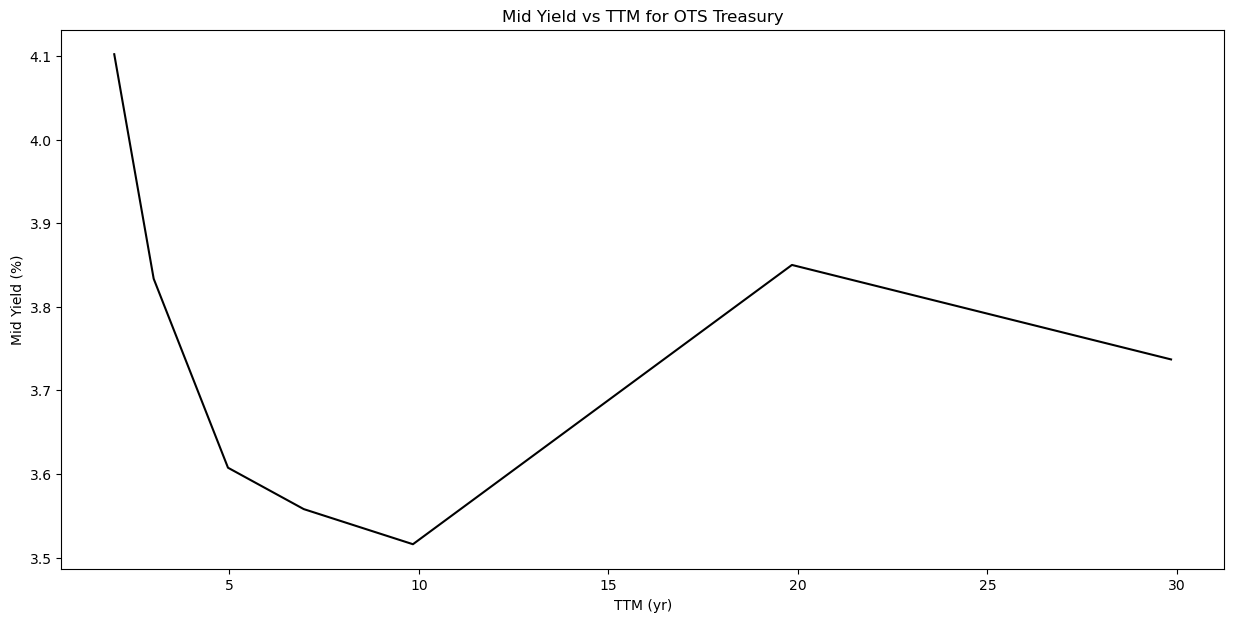

In [8]:
gov_otr_symbology_md = pd.merge(gov_otr_symbology, md, on='figi', how='inner', suffixes=('', '_y'))
gov_otr_symbology_md.rename(columns={'mid_clean': 'mid'}, inplace=True)
gov_otr_symbology_md['mid_yield'] = (gov_otr_symbology_md['ask_yield'] + gov_otr_symbology_md['bid_yield'])/2
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(gov_otr_symbology_md['TTM'], gov_otr_symbology_md['mid_yield'], color='black')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Mid Yield (%)')
ax.set_title('Mid Yield vs TTM for OTS Treasury')
plt.show()

### HW1Q3 - Underying treasury benchmarks and credit spreads
1. Use the column 'und_bench_yield' to identify the underlying benchmark bond for each issue. Add two new columns to the joint corporate bond dataframe.
*  `und_bench_yield` = underlying benchmark bond mid yield and
*  `credit_spread` = issue yield - underlying benchmark bond mid yield.
2. Plot a graph/scatter plot of credit spread curves by TTM (one line per issuer).
3. Add two new columns to the joint corporate bond dataframe:
*  `interp_tsy_yield` = interpolated treasury yield (using on-the-run treasuries only), matching the issue maturity
*  `g_spread` = issue yield - interp_tsy_yield.
4. Plot a graph/scatter plot of g-spread curves by TTM (one line per issuer).

In [9]:
corp_symbology_md['und_bench_yield'] = corp_symbology_md['und_bench_isin'].map(govt_symbology_md.set_index('isin')['mid_yield'])
corp_symbology_md['credit_spread'] = corp_symbology_md['mid_yield'] - corp_symbology_md['und_bench_yield']
corp_symbology_md = corp_symbology_md.dropna(subset=['credit_spread'])
corp_symbology_md.sort_values(by=['TTM'], inplace=True)
corp_symbology_md.reset_index(drop=True, inplace=True)
corp_symbology_md.head()

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,isin_y,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield,und_bench_yield,credit_spread
0,DIS,Corp,BBG00N36B7D0,USU25497AG02,DIS4809907,US91282CGU99,DIS 7 3/4 01/20/24,WALT DISNEY COMPANY/THE,EURO-DOLLAR,7.750,...,USU25497AG02,101.739,102.165,101.952,103.847,5.354,4.782,5.0680,4.102,0.9660
1,IBM,Corp,BBG005ZC4J89,US459200HU86,IBM4096360,US91282CGU99,IBM 3 5/8 02/12/24,IBM CORP,GLOBAL,3.625,...,US459200HU86,98.747,98.999,98.873,99.538,5.205,4.884,5.0445,4.102,0.9425
2,VZ,Corp,BBG00ZLKTDJ4,US92343VGF58,VZ5148416,US91282CGU99,VZ 0 3/4 03/22/24,VERIZON COMMUNICATIONS,GLOBAL,0.750,...,US92343VGF58,95.975,96.327,96.151,96.205,5.251,4.846,5.0485,4.102,0.9465
3,MS,Corp,BBG006DDT5Z2,US61746BDQ68,MS4119530,US91282CGU99,MS 3 7/8 04/29/24,MORGAN STANLEY,GLOBAL,3.875,...,US61746BDQ68,98.470,98.741,98.606,100.425,5.420,5.144,5.2820,4.102,1.1800
4,IBM,Corp,BBG00P3BLGV3,US459200JY80,IBM4832193,US91282CGU99,IBM 3 05/15/24,IBM CORP,GLOBAL,3.000,...,US459200JY80,98.057,98.258,98.158,99.433,4.875,4.678,4.7765,4.102,0.6745


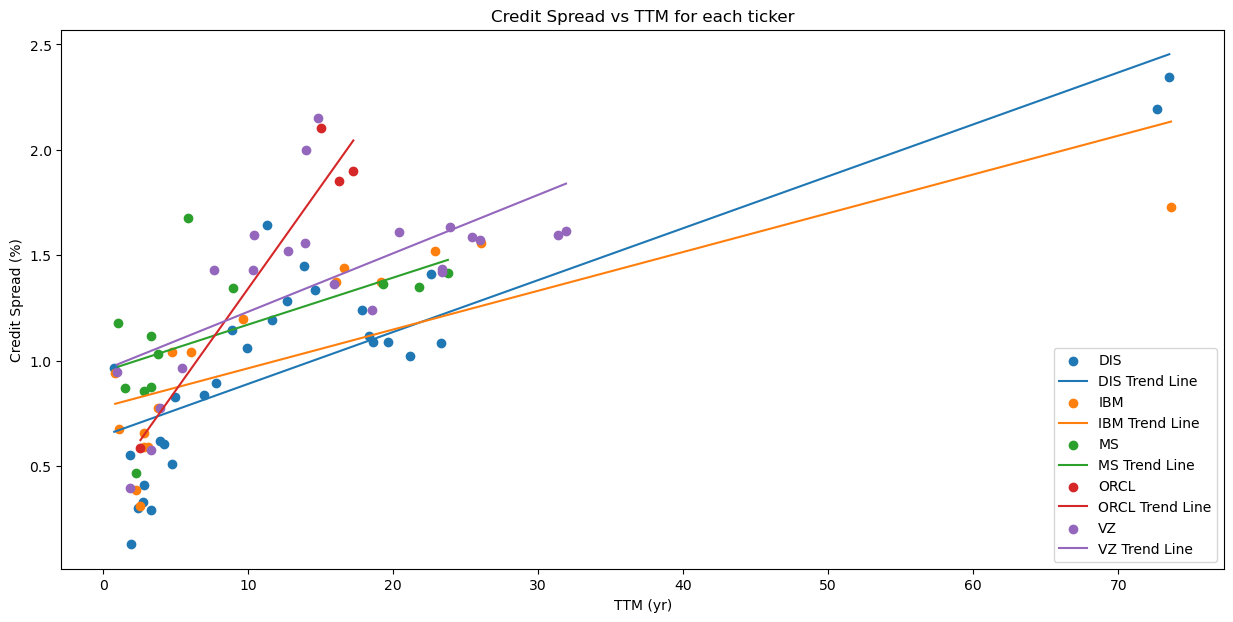

In [10]:
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md.groupby('ticker'):
    ax.scatter(group['TTM'], group['credit_spread'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['credit_spread'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('Credit Spread (%)')
ax.set_title('Credit Spread vs TTM for each ticker')
plt.legend()
plt.show()

In [13]:
corp_symbology_md = get_interp_tsy_yield(corp_symbology_md, gov_otr_symbology_md)
corp_symbology_md['g_spread'] = corp_symbology_md['mid_yield'] - corp_symbology_md['interp_tsy_yield']

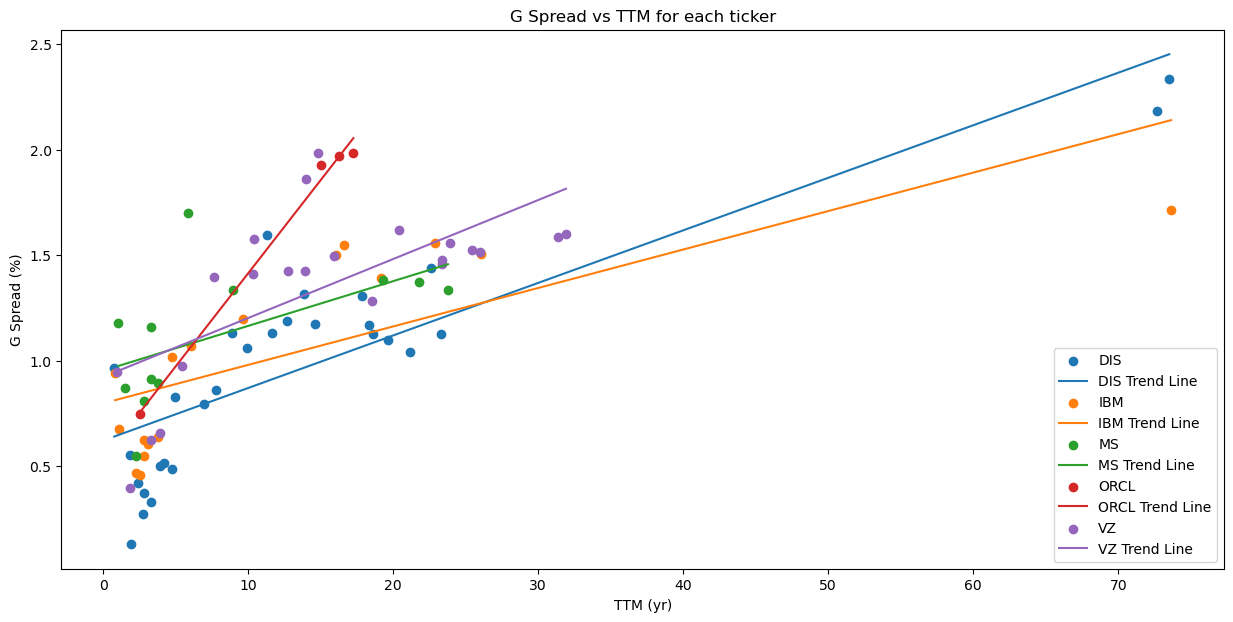

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))
for ticker, group in corp_symbology_md.groupby('ticker'):
    ax.scatter(group['TTM'], group['g_spread'], label=ticker)
    #add best fit line
    z = np.polyfit(group['TTM'], group['g_spread'], 1)
    p = np.poly1d(z)
    plt.plot(group['TTM'], p(group['TTM']), label = f'{ticker} Trend Line')
ax.set_xlabel('TTM (yr)')
ax.set_ylabel('G Spread (%)')
ax.set_title('G Spread vs TTM for each ticker')
plt.legend()
plt.show()

### HW2Q1 - Constructing fixed rate bonds
1. Load the `govt_symbology` and `corp_symbology` Excel files into one common dataframe, using the `corp_symbology` columns. Filter the dataframe and keep fixed rate bonds only: (cpn_type="FIXED").
2. Add function to construct generic fixed rate cashflow schedules from symbology data.
   1. Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object. `get_ql_date(date_str)` , `create_schedule_from_symbology(row)`.
   2. Use one row of the symbology dataframe as input to the function. Use `create_schedule_from_symbology(row)` internally to create the cashflow schedule.
3. Add function that returns a dataframe with (future) cash flows details for a bond object - `get_bond_cashflows(bond, calc_date)`.

### HW2Q2 HW2Q3 -  US Treasury yield curve calibration (On-The-Runs) | Pricing and risk metrics for US Treasury bonds
1. Restrict the symbology + market data dataframe to on-the-run US treasury notes only (excluding Treasury Bills) and create the treasury bond objects.
2. Calibrate the on-the-run treasury yield curve (bootstrapping). The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. `calibrate_yield_curve_from_frame(calc_date, treasury_details, price_quote_column_name)`.
3. Create a graph/scatter plot of the newly computed mid yields by maturity.
4. Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.
5. US Treasury pricing on the calibrated discount factor curve. You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
`bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)`
6. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield). Remember that DV01 = Dirty_Price * Duration
7. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

### HW2Q4 - Pricing and risk metrics for corporate bonds
1. Create the on-the-run corporate bond objects
2. Compute analytical Yields and Z-Spreads
3. Validate Z-Spread computation for a few fixed rate corporate bonds
4. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

### HW3Q1 - More details on callable bonds: "workout-date" and "yield-to-worst" calculations
1. Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.For each bond in the dataframe, compute the total number of outstanding calls.
2. Load symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.
3. Add a function to compute "workout date" and "yield-to-worst" for a fixed-rate callable bond
4. Compute "workout dates" and "yields-to-worst" for all fixed-rate callable bonds.For each fixed-rate callable bond in the symbology dataframe from 1b (using calc_date = '2023-04-14' and clean market prices):
   1. Compute the yield to maturity 
   2. Use the function from 1c to compute "workout date" and "yield-to-worst".

### HW3Q3 - US SOFR swap curve calibration as of 2023-04-28
1. Load and explore US SOFR swaps symbology and market data
2. Load the `sofr_swap_symbology`. Load the `sofr_swaps_market_data_eod`. Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.
3. Calibrate the US SOFR yield curve (via bootstrapping). Calibrate a smooth yield/discount factor curve from SOFR swaps.
4. Display the calibrated SOFR discount curve dataframe. Display the calibration details dataframe.
5. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves. Plot the SOFR zero rates and discount factor curves by maturity

### HW3Q4 - CDS Hazard Rate calibration and valuation
1. Follow Section "12. CDS Hazard Rate calibration + Pricing" in the QuantLib Intro notebook. Load and explore the CDS market data. Plot the historical time series of CDS Par Spreads for the available tenors.
2. Calibrate the IBM hazard rate curve as of 2023-04-28. Follow section 12a. Use the calibrated SOFR discount curve from 2b.
3. Plot the calibrated Hazard Rates and Survival Probability curves. Follow section 12b. Use the calibrated SOFR discount curve from 2b.
4. Compute the fair/par spread and PV of a CDS. Follow section 12c. Construct a CDS object with 100 bps coupon and 2027-06-20 maturity. Compute the fair/par spread and PV.

### HW4Q1 - Pricing risky bonds in the hazard rate model
1. Calibrate the following curves as of 2023-04-14:
- the "on-the-run" US Treasury curve,
- the US SOFR curve and 
- the IBM CDS hazard rate curve (on the top of SOFR discount curve).
2. Create the corresponding fixed rate bonds. Use the create_bond_from_symbology() function. List the bond cashflows using the get_bond_cashflows() function.
3. Compute CDS-implied (intrinsic) prices for the IBM fixd rate bonds. Price the bonds using the CDS-calibrated hazard rate curve (via RiskyBondEngine)
4. Compute the "intrinsic" vs market price basis for the bonds. Load the market clean prices and yields (mid quotes) from the market quotes dataframe as of 2023-04-14. Compute the basis between the "CDS-implied intrinsic" vs market values. 
- BasisInPrice = corpBondModelPrice - corpBondMarketPrice
- BasisInYield = corpBondModelYield - corpBondMarketYield

### HW4Q2 - Compute scenario sensitivities for risky bonds
1. Compute scenario IR01s for the bonds. Compute the scenario IR01 and Durations using a -1bp interest rate shock, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.
- IR01 = Dirty_Price * Duration
2. Compute scenario Convexities for the bonds. Compute the scenario Convexities using the +/-1bp interest rate shocks.
3. Compute scenario HR01s (hazard rate sensitivity) and CS01s (credit spread sensitivity) for the bonds. Apply a -1bp (parallel shift) scenario to the IBM CDS Par Spread quotes and calibrate the scenario hazard rate curve. Create a new scenario RiskyBondEngine, using the scenario hazard rate curve. Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped hazard rate curve) to obtain the -1bp scenario HR01 (hazard rate sensitivity).
4. The credit spread sensitivity CS01 is defined as CS01 = (ScenarioPrice - BasePrice) / (ScenarioYield - BasePYield) * 100.
5. Compute scenario Rec01 (recovery rate sensitivity) for the bonds. Apply a +1% scenario bump to the IBM recovery rate (flat_recovery_rate parameter will move from 40% to 41%). Create a new scenario RiskyBondEngine, using the scenario new recovery rate. Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped recovery rate) to obtain the +1% scenario REC01 (recovery rate sensitivity).

### HW4Q3 - Nelson-Siegel model for smooth hazard rate curves
1. Follow Lecture 4, Section 1 "Parametric Hazard Rate Models", Follow Section "13. Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the QuantLib Intro V3 notebook
2. Load the symbology + market data dataframes.
3. Calibrate the "on-the-run" US Treasury curve, which will be used as discount factor curve
4. Create the Nelson-Siegel curve shape (4 parameters) and compute the corresponding SSE function.
   1. For a given set of parameters, write a function to compute the SSE "Sum of Squared Errors" penalty function in price space (defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds).
   2. For each bond, compute the bond durations, using Section "9. Analytical Duration" in the QuantLib introductory notebook as a template.
   3. Use 1/Duration as SSE weights. You can ignore the liquidity adjuster for the purpose of this exercise.
5. Calibrate the Nelson-Siegel model parameters to obtain the smooth Verizon credit curve.
   1. Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 
   2. Create the calibrated/smooth credit curve corresponding to the optimal model parameters.
6. Compute smooth model prices, yields and "edges"
   1. Price all Verizon bonds on the calibrated credit curve and compute the corresponding yields.
   2. Plot the model vs market yields (Y-axis) by time to maturity (X-axis).
   3. Plot the edges in yield space (Y-axis) by time to maturity (X-axis).

### HW4Q4 - Pricing bonds in the Merton Structural Credit Model
1. Follow Lecture 4, Section 2 "Structural Credit Models"
2. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%
3. Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.
4. Risky Bond Valuation (Fair Value of Liabilities). Compute the fair value of the risky bond.
5. Flat yield, spread and hazard rate. Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default
  - Plot bond credit spreads as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.
6. Equity volatility. Compute the Equity Volatility.
7. What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?
8. Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.